# Data Preparation
Reusable functions for static (landscape) and dynamic (perimeter/weather) data preparation. The parameters that the user should define are:

1. Incident name
2. Ignition longitude
3. Ignition latitude
4. Radius in miles (for the initial bounding box)
5. Landscape filepath (e.g., ```landscape.lcp```)

This notebook defines functions for each data preparation step, then demonstrates them with the BORDER 2 fire as an example.

In [1]:
import sys
sys.path.insert(0, 'src')

import numpy as np
import pandas as pd
import geopandas as gpd
import requests
import json
import geojson
from datetime import datetime
import time
from pathlib import Path
from shapely.geometry import box, Point, Polygon
import matplotlib.pyplot as plt
from pyproj import Transformer
import contextily as ctx

from config import (
    DATA_DIR, OUTPUT_DIR, 
    FIREMAP_WX_URL,
    FARSITE_CRS
)
from firemap import fetch_fire_perimeters

---
# Part 1: Function Definitions

## 1.1 Landscape/Domain Functions

In [2]:
def create_bbox_from_point(lon, lat, radius_in_miles=10.0, write_geojson=False, output_path="initial_bbox.geojson"):
    """
    Create a bounding box with center point (lon, lat) and radius buffer.
    
    Args:
        lon: Longitude of center point (WGS84)
        lat: Latitude of center point (WGS84)
        radius_in_miles: Radius of bounding box in miles (default: 10.0)
        write_geojson: Whether to write bbox to GeoJSON file (default: False)
        output_path: Path for output GeoJSON if write_geojson=True
        
    Returns:
        GeoDataFrame with bounding box in EPSG:5070 (FARSITE CRS)
    """
    # Create center point
    center_point = Point(lon, lat)
    pt = gpd.GeoSeries([center_point], crs="EPSG:4326")
    
    # Project to local UTM for accurate buffering
    pt_utm = pt.to_crs(pt.estimate_utm_crs())
    
    # Create buffer
    radius_meters = radius_in_miles * 1609.344
    buffer_utm = pt_utm.buffer(radius_meters)
    
    # Get bounding box
    minx, miny, maxx, maxy = buffer_utm.total_bounds
    
    # Convert bbox corners back to lon/lat
    corners_utm = gpd.GeoSeries(
        [Point(minx, miny), Point(maxx, maxy)],
        crs=pt_utm.crs
    ).to_crs("EPSG:4326")
    
    min_lon, min_lat = corners_utm.iloc[0].x, corners_utm.iloc[0].y
    max_lon, max_lat = corners_utm.iloc[1].x, corners_utm.iloc[1].y
    
    # Build bbox polygon in WGS84
    bbox_polygon_wgs84 = Polygon([
        (min_lon, min_lat),
        (max_lon, min_lat),
        (max_lon, max_lat),
        (min_lon, max_lat),
        (min_lon, min_lat),
    ])
    
    # Create GeoDataFrame in WGS84 then convert to FARSITE CRS
    bbox_gdf = gpd.GeoDataFrame(
        [{'type': 'bounding_box', 'radius_miles': radius_in_miles}],
        geometry=[bbox_polygon_wgs84],
        crs="EPSG:4326"
    )
    bbox_gdf = bbox_gdf.to_crs(FARSITE_CRS)
    
    # Optional: Write to GeoJSON
    if write_geojson:
        bbox_feature = geojson.Feature(
            geometry=bbox_polygon_wgs84,
            properties={
                "type": "bounding_box",
                "radius_miles": radius_in_miles,
                "center_lon": lon,
                "center_lat": lat,
            }
        )
        feature_collection = geojson.FeatureCollection([bbox_feature])
        with open(output_path, "w", encoding="utf-8") as f:
            json.dump(feature_collection, f, indent=2)
        print(f"✓ Bounding box saved to {output_path}")
    
    return bbox_gdf


def verify_landscape_file(lcp_path):
    """
    Verify that a landscape (.lcp) file exists.
    
    Args:
        lcp_path: Path to landscape file
        
    Returns:
        bool: True if file exists, False otherwise
    """
    exists = Path(lcp_path).exists()
    
    if exists:
        print(f"✓ Landscape file found: {lcp_path}")
    else:
        print(f"✗ Landscape file not found: {lcp_path}")
        print("You need to generate or download a .lcp file for your domain.")
        print("See FARSITE documentation for landscape file creation.")
    
    return exists

## 1.2 Perimeter Retrieval Functions

In [3]:
def fetch_fire_perimeters_firms_ogc(fire_name="BORDER 2", bbox=None, 
                                    start_date=None, end_date=None,
                                    fire_id=None, verbose=True):
    """
    Fetch fire perimeters from FIRMS OGC API.
    
    Args:
        fire_name: Name of fire (for display only)
        bbox: Bounding box [minLon, minLat, maxLon, maxLat] in WGS84
        start_date: Start date (YYYY-MM-DD or datetime)
        end_date: End date (YYYY-MM-DD or datetime)
        fire_id: Fire ID to filter (required for accurate results)
        verbose: Print progress
        
    Returns:
        GeoDataFrame with perimeters (already in EPSG:5070, sorted oldest→newest)
    """
    if verbose:
        print(f"Fetching perimeters for: {fire_name}")
        print(f"Data source: FIRMS OGC API (actual perimeter polygons)")
    
    # Border 2 defaults
    if bbox is None:
        bbox = [-117.36, 32.54, -116.04, 33.31]  # San Diego County
    
    if start_date is None:
        start_date = "2025-01-23"
    
    if end_date is None:
        end_date = "2025-01-30"
    
    # Convert dates to ISO format
    if isinstance(start_date, str) and 'T' not in start_date:
        start_date = f"{start_date}T00:00:00"
    if isinstance(end_date, str) and 'T' not in end_date:
        end_date = f"{end_date}T23:59:59"
    
    # Fetch from FIRMS
    from firms_utils import FIRMSPerimeters
    
    client = FIRMSPerimeters()
    perimeters_gdf = client.fetch_fire_perimeters(
        bbox=bbox,
        start_datetime=start_date,
        end_datetime=end_date,
        fire_id=fire_id,
        progress=verbose
    )
    
    # Already sorted oldest→newest and in EPSG:5070
    if verbose:
        print(f"\n✓ Retrieved {len(perimeters_gdf)} perimeter updates")
        print(f"Order: Index 0 = oldest, Index {len(perimeters_gdf)-1} = newest")
    
    return perimeters_gdf

In [4]:
def extract_fire_timeline(perimeters_gdf, verbose=True):
    """
    Extract ignition and containment dates from perimeter GeoDataFrame.
    
    Args:
        perimeters_gdf: GeoDataFrame with perimeter updates (must have 'datetime' column)
        verbose: Print timeline information
        
    Returns:
        dict with keys: 'ignition_date', 'containment_date', 'duration', 'n_updates'
    """
    ignition_date = perimeters_gdf['datetime'].iloc[0]
    containment_date = perimeters_gdf['datetime'].iloc[-1]
    duration = containment_date - ignition_date
    n_updates = len(perimeters_gdf)
    
    timeline = {
        'ignition_date': ignition_date,
        'containment_date': containment_date,
        'duration': duration,
        'n_updates': n_updates
    }
    
    if verbose:
        print(f"\nFire Timeline:")
        print(f"  First observation (ignition): {ignition_date}")
        print(f"  Last observation (containment): {containment_date}")
        print(f"  Total duration: {duration}")
        print(f"  Number of updates: {n_updates}")
    
    return timeline

## 1.3 Weather Data Functions

In [5]:
def fetch_weather_data(lat, lon, start_time, end_time, verbose=True):
    """
    Fetch weather observations from Firemap API.
    
    Args:
        lat: Latitude (WGS84)
        lon: Longitude (WGS84)
        start_time: Start datetime (ISO format string or datetime)
        end_time: End datetime (ISO format string or datetime)
        verbose: Print progress messages
        
    Returns:
        dict with keys: 'location', 'time_range', 'wind_speed', 'wind_direction'
    """
    # Convert datetimes to ISO format if needed
    if isinstance(start_time, pd.Timestamp):
        start_time = start_time.isoformat()
    if isinstance(end_time, pd.Timestamp):
        end_time = end_time.isoformat()
    
    if verbose:
        print(f"Querying weather data...")
        print(f"  Location: {lat:.4f}, {lon:.4f}")
        print(f"  From: {start_time}")
        print(f"  To: {end_time}")
    
    # Query Firemap API
    timestamp = int(time.time() * 1000)
    wx_params = {
        'selection': 'closestTo',
        'lat': str(lat),
        'lon': str(lon),
        'observable': ['wind_speed', 'wind_direction'],
        'from': start_time,
        'to': end_time,
        'callback': 'wxData',
        '_': str(timestamp)
    }
    
    wx_response = requests.get(FIREMAP_WX_URL, params=wx_params)
    wx_text = wx_response.text.strip()
    
    # Remove JSONP wrapper
    if wx_text.startswith('wxData(') and wx_text.endswith(')'):
        wx_json = wx_text[len('wxData('):-1]
        wx_obs = json.loads(wx_json)
    else:
        wx_obs = wx_response.json()
    
    # Extract wind data
    wind_speed_list = wx_obs["features"][0]["properties"]["wind_speed"]
    wind_direction_list = wx_obs["features"][0]["properties"]["wind_direction"]
    
    weather_data = {
        "location": {"lat": lat, "lon": lon},
        "time_range": {"start": start_time, "end": end_time},
        "wind_speed": wind_speed_list,
        "wind_direction": wind_direction_list
    }
    
    if verbose:
        print(f"\n✓ Retrieved {len(wind_speed_list)} weather observations")
        print(f"  Wind speed: {min(wind_speed_list):.1f} - {max(wind_speed_list):.1f} mph (mean: {np.mean(wind_speed_list):.1f})")
        print(f"  Wind direction: {min(wind_direction_list):.0f} - {max(wind_direction_list):.0f}° (mean: {np.mean(wind_direction_list):.0f})")
    
    return weather_data


def get_weather_location_from_fire(perimeters_gdf, to_wgs84=True):
    """
    Get weather query location from fire perimeter centroid.
    
    Args:
        perimeters_gdf: GeoDataFrame with fire perimeters
        to_wgs84: Convert to WGS84 coordinates (required for weather API)
        
    Returns:
        tuple: (lat, lon) in WGS84 if to_wgs84=True, else in original CRS
    """
    # Use first perimeter centroid
    fire_centroid = perimeters_gdf.geometry.iloc[0].centroid
    
    if to_wgs84:
        # Convert to WGS84 for weather API
        transformer = Transformer.from_crs(perimeters_gdf.crs, "EPSG:4326", always_xy=True)
        lon_wgs, lat_wgs = transformer.transform(fire_centroid.x, fire_centroid.y)
        return lat_wgs, lon_wgs
    else:
        return fire_centroid.y, fire_centroid.x

## 1.4 Visualization Functions

In [6]:
def plot_perimeter_evolution(perimeters_gdf, fire_name="Fire", add_basemap=True):
    """
    Plot fire perimeter evolution over time with OpenStreetMap basemap.
    
    Args:
        perimeters_gdf: GeoDataFrame with perimeter updates (must have 'datetime' column)
        fire_name: Name of fire for plot title
        add_basemap: Add OpenStreetMap basemap (default: True)
    """
    fig, ax = plt.subplots(1, 1, figsize=(14, 14))
    
    n_perims = len(perimeters_gdf)
    colors = plt.cm.Reds(np.linspace(0.3, 1, n_perims))
    
    # Plot perimeters
    for idx, (_, row) in enumerate(perimeters_gdf.iterrows()):
        boundary = row.geometry.boundary
        if boundary.geom_type == 'LineString':
            x, y = boundary.xy
            ax.plot(x, y, color=colors[idx], linewidth=2.5, zorder=2)
        elif boundary.geom_type == 'MultiLineString':
            for line in boundary.geoms:
                x, y = line.xy
                ax.plot(x, y, color=colors[idx], linewidth=2.5, zorder=2)
    
    # Add basemap
    if add_basemap:
        try:
            ctx.add_basemap(
                ax=ax, 
                source=ctx.providers.OpenStreetMap.Mapnik, 
                crs=FARSITE_CRS,
                alpha=0.6,
                zorder=1
            )
        except Exception as e:
            print(f"Could not add basemap: {e}")
    
    ax.set_aspect('equal')
    
    start_date = perimeters_gdf['datetime'].iloc[0].date()
    end_date = perimeters_gdf['datetime'].iloc[-1].date()
    ax.set_title(f"{fire_name} - Perimeter Evolution\n{start_date} to {end_date}", fontsize=16, weight='bold')
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=plt.Normalize(vmin=0, vmax=n_perims-1))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, fraction=0.03, pad=0.04)
    cbar.set_label('Time progression (older → newer)', fontsize=12)
    
    plt.tight_layout()
    plt.show()



def plot_weather_data(weather_data):
    """
    Plot weather observations (wind speed and direction).
    
    Args:
        weather_data: Dictionary returned by fetch_weather_data()
    """
    wind_speed = weather_data['wind_speed']
    wind_direction = weather_data['wind_direction']
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
    
    ax1.plot(wind_speed, 'b-', linewidth=1)
    ax1.axhline(np.mean(wind_speed), color='r', linestyle='--', 
               label=f'Mean: {np.mean(wind_speed):.1f} mph')
    ax1.set_ylabel('Wind Speed (mph)')
    ax1.set_title('Weather Observations')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(wind_direction, 'g-', linewidth=1)
    ax2.axhline(np.mean(wind_direction), color='r', linestyle='--', 
               label=f'Mean: {np.mean(wind_direction):.0f}°')
    ax2.set_ylabel('Wind Direction (degrees)')
    ax2.set_xlabel('Observation Index')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 1.5 Save/Load Functions

In [7]:
def save_workflow_config(fire_name, lcp_path, timeline, weather_location, 
                        domain_bounds=None, output_path=None):
    """
    Save complete workflow configuration.
    
    Args:
        fire_name: Name of fire
        lcp_path: Path to landscape file
        timeline: Dictionary from extract_fire_timeline()
        weather_location: (lat, lon) tuple
        domain_bounds: Optional domain bounds
        output_path: Output path (default: DATA_DIR/workflow_config.json)
        
    Returns:
        Path to saved configuration file
    """
    config_data = {
        # Static data
        "lcp_path": str(lcp_path),
        "domain_bounds": domain_bounds,
        "crs": FARSITE_CRS,
        
        # Fire information
        "fire_name": fire_name,
        "ignition_date": timeline['ignition_date'].isoformat(),
        "containment_date": timeline['containment_date'].isoformat(),
        "n_perimeters": timeline['n_updates'],
        
        # Weather location
        "weather_location": {"lat": weather_location[0], "lon": weather_location[1]},
    }
    
    if output_path is None:
        output_path = DATA_DIR / "workflow_config.json"
    
    with open(output_path, 'w') as f:
        json.dump(config_data, f, indent=2)
    
    print(f"✓ Configuration saved to {output_path}")
    return output_path


def save_perimeters(perimeters_gdf, fire_name, output_dir=None):
    """
    Save perimeter GeoDataFrame to file.
    
    Args:
        perimeters_gdf: GeoDataFrame with perimeters
        fire_name: Name of fire
        output_dir: Output directory (default: OUTPUT_DIR)
        
    Returns:
        Path to saved file
    """
    if output_dir is None:
        output_dir = OUTPUT_DIR
    
    filename = f"{fire_name.lower().replace(' ', '_')}_perimeters.geojson"
    output_path = output_dir / filename
    
    perimeters_gdf.to_file(output_path, driver="GeoJSON")
    
    print(f"✓ Perimeters saved to {output_path}")
    print(f"  Order: Index 0 = oldest (ignition), Index {len(perimeters_gdf)-1} = newest (containment)")
    
    return output_path


def save_weather_data(weather_data, output_dir=None):
    """
    Save weather data to JSON file.
    
    Args:
        weather_data: Dictionary from fetch_weather_data()
        output_dir: Output directory (default: DATA_DIR)
        
    Returns:
        Path to saved file
    """
    if output_dir is None:
        output_dir = DATA_DIR
    
    output_path = output_dir / "weather_observations.json"
    
    with open(output_path, 'w') as f:
        json.dump(weather_data, f, indent=2)
    
    print(f"✓ Weather data saved to {output_path}")
    
    return output_path

---
# Part 2: Example - BORDER 2 Fire

Demonstration of complete workflow using BORDER 2 fire.

## 2.1 Define Fire Parameters

In [8]:
# BORDER 2 fire parameters
FIRE_NAME = "BORDER 2"
IGNITION_LON = -116.88  # Approximate ignition point
IGNITION_LAT = 32.61
DOMAIN_RADIUS_MILES = 15.0  # Bounding box radius
LCP_PATH = "landscape.lcp"  # Path to landscape file

print("BORDER 2 Fire Configuration:")
print(f"  Ignition point: ({IGNITION_LAT}, {IGNITION_LON})")
print(f"  Domain radius: {DOMAIN_RADIUS_MILES} miles")
print(f"  Landscape file: {LCP_PATH}")

BORDER 2 Fire Configuration:
  Ignition point: (32.61, -116.88)
  Domain radius: 15.0 miles
  Landscape file: landscape.lcp


## 2.2 Create Domain Bounding Box

✓ Bounding box saved to /home/jovyan/work/wildfire-digital-twin/outputs/border2_bbox.geojson

Bounding box bounds (EPSG:5070): [-1961780.30316398  1244059.06073762 -1904282.46253171  1301892.06737854]


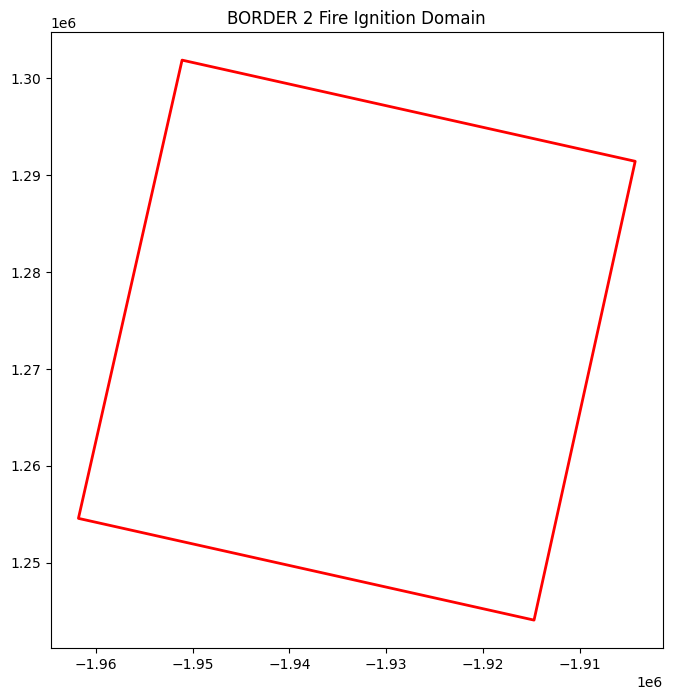

In [9]:
# Create bounding box around ignition point
bbox_gdf = create_bbox_from_point(
    lon=IGNITION_LON,
    lat=IGNITION_LAT,
    radius_in_miles=DOMAIN_RADIUS_MILES,
    write_geojson=True,
    output_path=OUTPUT_DIR / "border2_bbox.geojson"
)

print(f"\nBounding box bounds (EPSG:5070): {bbox_gdf.total_bounds}")

# Visualize
bbox_gdf.plot(figsize=(8, 8), edgecolor='red', facecolor='none', linewidth=2)
plt.title('BORDER 2 Fire Ignition Domain')
plt.show()

## 2.3 Verify Landscape File

In [10]:
# Check if landscape file exists
lcp_exists = verify_landscape_file(LCP_PATH)

✗ Landscape file not found: landscape.lcp
You need to generate or download a .lcp file for your domain.
See FARSITE documentation for landscape file creation.


In [11]:
list(bbox_gdf.to_crs(4326).geometry[0].bounds)

[-117.13695959016208, 32.39221218349534, -116.6217951143133, 32.82724915268331]

## 2.4 Fetch Fire Perimeters

In [12]:
# ── Fetch perimeters from WIFIRE Firemap ──────────────────────────────────
FIRE_NAME = "BORDER 2"
YEAR = 2025

perimeters_gdf = fetch_fire_perimeters(fire_name=FIRE_NAME, year=YEAR, verbose=True)

# ── Verify time progression ───────────────────────────────────────────────
print(f"\nTime progression check:")
for i in range(len(perimeters_gdf)):
    row = perimeters_gdf.iloc[i]
    print(f"  [{i}] {row['datetime'].date()}  —  {row.geometry.area/1e6:.2f} km²")

diffs = perimeters_gdf['datetime'].diff().dropna()
print(f"\nTime deltas between perimeters:")
for i, d in enumerate(diffs):
    print(f"  [{i}→{i+1}] {d}")

# ── Save perimeters ───────────────────────────────────────────────────────
perimeters_path = OUTPUT_DIR / f"{FIRE_NAME.lower().replace(' ', '_')}_perimeters.geojson"

# GeoJSON doesn't support timezone-aware datetimes — strip tz before saving
save_gdf = perimeters_gdf.copy()
save_gdf['datetime'] = save_gdf['datetime'].dt.strftime('%Y-%m-%dT%H:%M:%S')

save_gdf.to_file(perimeters_path, driver="GeoJSON")
print(f"\n✓ Saved {len(perimeters_gdf)} perimeters to {perimeters_path}")

Fetching perimeters for 'BORDER 2' (2025)...
  Retrieved 6 perimeter(s)

✓ 6 perimeters ready
  Oldest: 2025-01-23 00:00:00
  Newest: 2025-01-26 00:00:00
  Area range: 2.29 – 26.67 km²

  Perimeter timeline:
    [0] 2025-01-23  —  2.29 km²  (nan acres)
    [1] 2025-01-23  —  2.29 km²  (567 acres)
    [2] 2025-01-23  —  2.29 km²  (566 acres)
    [3] 2025-01-24  —  17.14 km²  (4235 acres)
    [4] 2025-01-24  —  25.33 km²  (6273 acres)
    [5] 2025-01-26  —  26.67 km²  (6625 acres)

Time progression check:
  [0] 2025-01-23  —  2.29 km²
  [1] 2025-01-23  —  2.29 km²
  [2] 2025-01-23  —  2.29 km²
  [3] 2025-01-24  —  17.14 km²
  [4] 2025-01-24  —  25.33 km²
  [5] 2025-01-26  —  26.67 km²

Time deltas between perimeters:
  [0→1] 0 days 00:00:00
  [1→2] 0 days 00:00:00
  [2→3] 1 days 00:00:00
  [3→4] 0 days 00:00:00
  [4→5] 2 days 00:00:00

✓ Saved 6 perimeters to /home/jovyan/work/wildfire-digital-twin/outputs/border_2_perimeters.geojson


## 2.5 Extract Fire Timeline

In [13]:
# Get ignition and containment dates
timeline = extract_fire_timeline(perimeters_gdf, verbose=True)


Fire Timeline:
  First observation (ignition): 2025-01-23 00:00:00
  Last observation (containment): 2025-01-26 00:00:00
  Total duration: 3 days 00:00:00
  Number of updates: 6


## 2.6 Visualize Perimeter Evolution

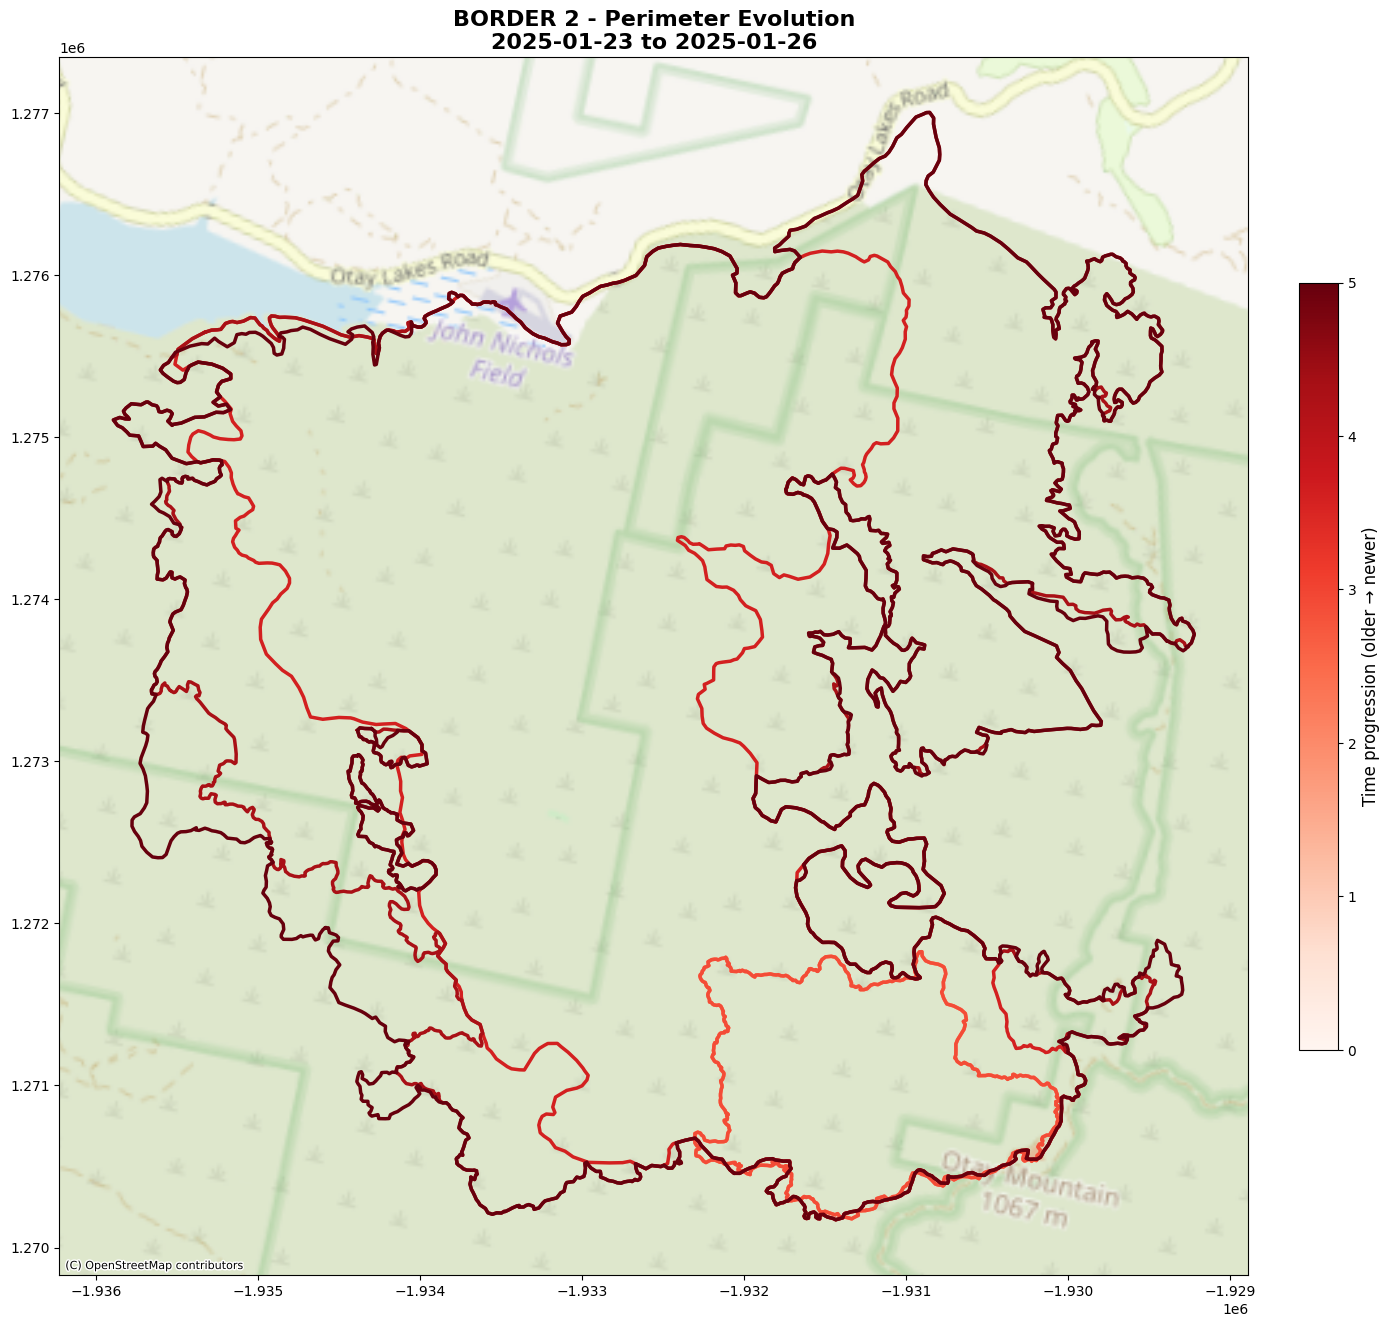

In [14]:
# Plot fire growth over time
plot_perimeter_evolution(perimeters_gdf, fire_name=FIRE_NAME)

## 2.7 Fetch Weather Data

In [15]:
# Get weather station location from fire centroid
wx_lat, wx_lon = get_weather_location_from_fire(perimeters_gdf, to_wgs84=True)

print(f"Weather query location: {wx_lat:.4f}, {wx_lon:.4f}")

Weather query location: 32.5959, -116.8571


In [16]:
# Fetch weather for entire fire duration
weather_data = fetch_weather_data(
    lat=wx_lat,
    lon=wx_lon,
    start_time=timeline['ignition_date'],
    end_time=timeline['containment_date'],
    verbose=True
)

Querying weather data...
  Location: 32.5959, -116.8571
  From: 2025-01-23T00:00:00
  To: 2025-01-26T00:00:00

✓ Retrieved 397 weather observations
  Wind speed: 0.8 - 17.4 mph (mean: 6.3)
  Wind direction: 6 - 255° (mean: 106)


## 2.8 Visualize Weather Data

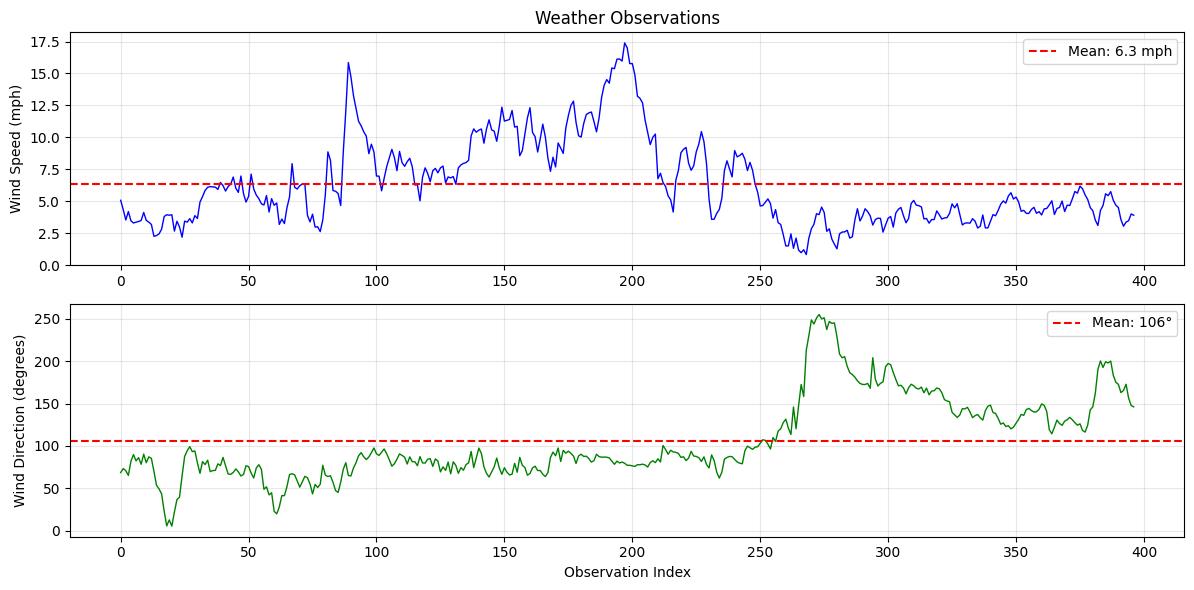

In [17]:
# Plot weather observations
plot_weather_data(weather_data)

## 2.9 Save All Data

In [18]:
# ── Extract timeline ──────────────────────────────────────────────────────
ignition_date    = perimeters_gdf['datetime'].iloc[0]
containment_date = perimeters_gdf['datetime'].iloc[-1]
duration_days    = (containment_date - ignition_date).days

print(f"Ignition:    {ignition_date}")
print(f"Containment: {containment_date}")
print(f"Duration:    {duration_days} days")

# ── Get weather query location (centroid of first perimeter in WGS84) ─────
first_perim_wgs84 = perimeters_gdf.iloc[[0]].to_crs("EPSG:4326")
centroid = first_perim_wgs84.geometry.centroid.iloc[0]
wx_lat, wx_lon = centroid.y, centroid.x

# ── Save config ───────────────────────────────────────────────────────────
workflow_config = {
    "fire_name":         FIRE_NAME,
    "year":              YEAR,
    "lcp_path":          str(LCP_PATH),
    "ignition_date":     ignition_date.isoformat(),
    "containment_date":  containment_date.isoformat(),
    "duration_days":     duration_days,
    "n_perimeters":      len(perimeters_gdf),
    "perimeters_path":   str(perimeters_path),
    "weather_location":  {"lat": wx_lat, "lon": wx_lon},
    "data_source":       "WIFIRE Firemap WFS (view_historical_fires)"
}

config_path = DATA_DIR / "workflow_config.json"
with open(config_path, 'w') as f:
    json.dump(workflow_config, f, indent=2)

print(f"✓ Config saved to {config_path}")
print(json.dumps(workflow_config, indent=2))

Ignition:    2025-01-23 00:00:00
Containment: 2025-01-26 00:00:00
Duration:    3 days
✓ Config saved to /home/jovyan/work/wildfire-digital-twin/data/workflow_config.json
{
  "fire_name": "BORDER 2",
  "year": 2025,
  "lcp_path": "landscape.lcp",
  "ignition_date": "2025-01-23T00:00:00",
  "containment_date": "2025-01-26T00:00:00",
  "duration_days": 3,
  "n_perimeters": 6,
  "perimeters_path": "/home/jovyan/work/wildfire-digital-twin/outputs/border_2_perimeters.geojson",
  "weather_location": {
    "lat": 32.595886593540015,
    "lon": -116.85708743001499
  },
  "data_source": "WIFIRE Firemap WFS (view_historical_fires)"
}


/tmp/ipykernel_279/59887655.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = first_perim_wgs84.geometry.centroid.iloc[0]


## 2.10 Summary

In [19]:
# Print summary
print("\n" + "="*60)
print(f"DATA PREPARATION SUMMARY")
print("="*60)
print(f"\nFire: {FIRE_NAME} ({YEAR})")
print(f"Data source: WIFIRE Firemap WFS")
print(f"\nPerimeters:")
print(f"  Total updates: {len(perimeters_gdf)}")
print(f"  Ignition:    {timeline['ignition_date']}")
print(f"  Containment: {timeline['containment_date']}")
print(f"  Duration:    {timeline['duration']}")
print(f"\nPerimeter progression:")
for i, row in perimeters_gdf.iterrows():
    print(f"  [{i}] {row['datetime'].date()}  —  {row.geometry.area/1e6:.2f} km²")
print(f"\nWeather query location: {wx_lat:.4f}, {wx_lon:.4f}")
print(f"\nSaved files:")
print(f"  - {perimeters_path}")
print(f"  - {config_path}")


DATA PREPARATION SUMMARY

Fire: BORDER 2 (2025)
Data source: WIFIRE Firemap WFS

Perimeters:
  Total updates: 6
  Ignition:    2025-01-23 00:00:00
  Containment: 2025-01-26 00:00:00
  Duration:    3 days 00:00:00

Perimeter progression:
  [0] 2025-01-23  —  2.29 km²
  [1] 2025-01-23  —  2.29 km²
  [2] 2025-01-23  —  2.29 km²
  [3] 2025-01-24  —  17.14 km²
  [4] 2025-01-24  —  25.33 km²
  [5] 2025-01-26  —  26.67 km²

Weather query location: 32.5959, -116.8571

Saved files:
  - /home/jovyan/work/wildfire-digital-twin/outputs/border_2_perimeters.geojson
  - /home/jovyan/work/wildfire-digital-twin/data/workflow_config.json
